In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv1D, Conv1DTranspose, LeakyReLU, BatchNormalization, Embedding, Multiply
from keras.layers import Dropout
from keras.utils import to_categorical
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Define the generator network:

from keras.utils import to_categorical

latent_dim = 100
num_classes = 10
time_series_length = 100
epochs = 5000
batch_size = 32

def build_generator(latent_dim, num_classes, time_series_length):
    input_noise = Input(shape=(latent_dim,))
    input_label = Input(shape=(num_classes,))
    label_embedding = Dense(latent_dim)(input_label)
    model_input = Multiply()([input_noise, label_embedding])
    
    x = Dense(128)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(time_series_length, activation="tanh")(x)
    model = Model([input_noise, input_label], x)
    
    return model

generator = build_generator(latent_dim, num_classes, time_series_length)

def build_discriminator(num_classes, time_series_length):
    input_data = Input(shape=(time_series_length,))
    input_label = Input(shape=(num_classes,))
    label_embedding = Dense(time_series_length)(input_label)
    label_embedding = Reshape((time_series_length, 1))(label_embedding)
    model_input = Reshape((time_series_length, 1))(input_data)
    model_input = Concatenate(axis=-1)([model_input, label_embedding])

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(model_input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model([input_data, input_label], x, name="discriminator")
    return model

discriminator = build_discriminator(num_classes, time_series_length)

def build_cgan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    label = Input(shape=(num_classes,))
    time_series = generator([z, label])
    validity = discriminator([time_series, label])
    cgan = Model([z, label], validity)
    
    return cgan

cgan = build_cgan(generator, discriminator)

def load_sine_wave(num_samples, time_series_length):
    # Generate sine wave data with specified phase shifts
    data = np.empty((num_samples, time_series_length))
    phase_shifts = [0,20,40,60,80,100,120,140,160,180]
    for i, phi in enumerate(phase_shifts):
        t = np.linspace(0, 2*np.pi, time_series_length)
        data[i] = np.sin(t + phi)

    # Generate corresponding one-hot encoded labels
    labels = [0,20,40,60,80,100,120,140,160,180]

    # map labels into a range of 0-9
    le = LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)

    labels = to_categorical(labels, num_classes=10)

    return data, labels

latent_dim = 100
num_classes = 10
time_series_length = 100
epochs = 5000
batch_size = 32

# Build the generator, discriminator, and CGAN models
generator = build_generator(latent_dim, num_classes, time_series_length)
discriminator = build_discriminator(num_classes, time_series_length)
cgan = build_cgan(generator, discriminator)

# Compile the discriminator and CGAN models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Load data
x_train, y_train = load_sine_wave(num_classes, time_series_length)

for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
#     print(f"IDX shape: {idx.shape}")
    real_time_series = x_train[idx]
#     print(f"real_time_series shape: {real_time_series.shape}")
    labels = y_train[idx]
#     print(f"labels shape: {labels.shape}")
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
#     print(f"noise shape: {noise.shape}")
    gen_time_series = generator.predict([noise, labels],verbose=0)
#     print(f"gen_time_series shape: {gen_time_series.shape}")

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([real_time_series, labels], np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([gen_time_series, labels], np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #  Train Generator

    # Generate a batch of noise and labels
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
#     print(f"noise shape: {noise.shape}")
    sampled_labels = np.random.randint(0, num_classes, batch_size)
    one_hot_labels = to_categorical(sampled_labels, num_classes=num_classes)
    g_loss = cgan.train_on_batch([noise, one_hot_labels], np.ones((batch_size, 1)))
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, D loss: {d_loss[0]}, G loss: {g_loss}")

# Save the generator model
generator.save('generator_model.h5')

Epoch: 0, D loss: 0.6821337342262268, G loss: 0.6543407440185547
Epoch: 100, D loss: 0.6599555313587189, G loss: 0.3945062756538391
Epoch: 200, D loss: 0.7746419608592987, G loss: 0.35942596197128296
Epoch: 300, D loss: 0.8153250366449356, G loss: 0.33107930421829224
Epoch: 400, D loss: 0.7945103496313095, G loss: 0.3313533663749695
Epoch: 500, D loss: 0.7776176333427429, G loss: 0.37226831912994385
Epoch: 600, D loss: 0.8130301535129547, G loss: 0.34506168961524963
Epoch: 700, D loss: 0.7712242156267166, G loss: 0.3729897737503052
Epoch: 800, D loss: 0.7825500518083572, G loss: 0.3566966652870178
Epoch: 900, D loss: 0.768839068710804, G loss: 0.3668321371078491
Epoch: 1000, D loss: 0.8039446324110031, G loss: 0.438595175743103
Epoch: 1100, D loss: 0.7255080342292786, G loss: 0.4271986484527588
Epoch: 1200, D loss: 0.7116426602005959, G loss: 0.42315226793289185
Epoch: 1300, D loss: 0.6990854367613792, G loss: 0.4871429204940796
Epoch: 1400, D loss: 0.6890219487249851, G loss: 0.513682

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_and_plot_data(num_instances, desired_class):
    # create a figure and axis object
    fig, ax = plt.subplots()
    
    # plot each instance on the same axis object
    for i in range(num_instances):
        latent_points = np.random.normal(0, 1, (1, latent_dim))
        label = np.zeros((1, num_classes))
        label[0, desired_class] = 1  # set the desired class to 1
        generated_data = generator.predict([latent_points, label],verbose=0)
        
        x = np.arange(0, generated_data.shape[1])
        y = generated_data[0]
        ax.plot(x, y, label=f"Instance {i+1}")
        
    ax.set_title(f"Generated Time Series Data for Class {desired_class}")
    ax.legend()
    plt.show()

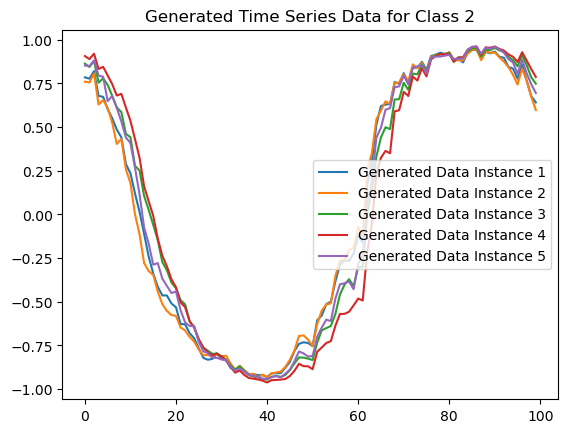

In [9]:
generate_and_plot_data(5,2)

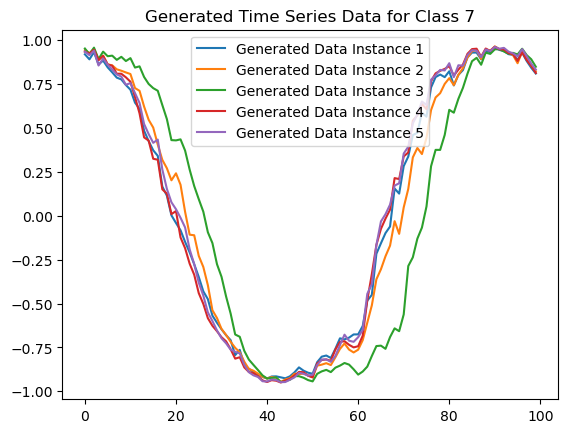

In [11]:
generate_and_plot_data(5,7)